# Homework: TensorFlow Hub
## Anthony Martinez | amm180005

[TensorFlow Hub](http://tensorflow.org/hub) is an online repository of already trained TensorFlow models that you can use.
These models can either be used as is, or they can be used for Transfer Learning.

Transfer learning is a process where you take an existing trained model, and extend it to do additional work. This involves leaving the bulk of the model unchanged, while adding and retraining the final layers, in order to get a different set of possible outputs.

Here, you can see all the models available in [TensorFlow Module Hub](https://tfhub.dev/).

Before starting this Colab, you should reset the Colab environment by selecting `Runtime -> Reset all runtimes...` from menu above.

# Imports


Some normal imports we've seen before. The new one is importing tensorflow_hub which this Colab will make heavy use of.

In [3]:
import tensorflow as tf

In [4]:
import numpy as np
import matplotlib.pyplot as plt

import tensorflow_hub as hub
import tensorflow_datasets as tfds

from tensorflow.keras import layers

In [5]:
import logging
logger = tf.get_logger()
logger.setLevel(logging.ERROR)

# Download the Flowers Dataset using TensorFlow Datasets

In the cell below you will download the Flowers dataset using TensorFlow Datasets. If you look at the [TensorFlow Datasets documentation](https://www.tensorflow.org/datasets/datasets#tf_flowers) you will see that the name of the Flowers dataset is `tf_flowers`. You can also see that this dataset is only split into a TRAINING set. You will therefore have to use `tfds.splits` to split this training set into to a `training_set` and a `validation_set`. Do a `[70, 30]` split such that 70 corresponds to the `training_set` and 30 to the `validation_set`. Then load the `tf_flowers` dataset using `tfds.load`. Make sure the `tfds.load` function uses the all the parameters you need, and also make sure it returns the dataset info, so we can retrieve information about the datasets.


In [6]:
(training_set, validation_set), dataset_info = tfds.load(
    'tf_flowers',
    split=['train[:70%]', 'train[70%:]'],
    with_info=True,
    as_supervised=True,
)

local data directory. If you'd instead prefer to read directly from our public
GCS bucket (recommended if you're running on GCP), you can instead pass
`try_gcs=True` to `tfds.load` or set `data_dir=gs://tfds-data/datasets`.



Dl Completed...:   0%|          | 0/5 [00:00<?, ? file/s]


Dataset tf_flowers downloaded and prepared to /root/tensorflow_datasets/tf_flowers/3.0.1. Subsequent calls will reuse this data.


# TODO: Print Information about the Flowers Dataset

Now that you have downloaded the dataset, use the dataset info to print the number of classes in the dataset, and also write some code that counts how many images we have in the training and validation sets. 

In [27]:
num_classes = dataset_info.features['label'].num_classes

# making sure dataset has been downloaded
print(dataset_info)

# count amount of images in training and validation sets
num_training_examples = tf.data.experimental.cardinality(training_set)
num_validation_examples = tf.data.experimental.cardinality(validation_set)


print('Total Number of Classes: {}'.format(num_classes))
print('Total Number of Training Images: {}'.format(num_training_examples))
print('Total Number of Validation Images: {} \n'.format(num_validation_examples))

tfds.core.DatasetInfo(
    name='tf_flowers',
    version=3.0.1,
    description='A large set of images of flowers',
    homepage='https://www.tensorflow.org/tutorials/load_data/images',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=5),
    }),
    total_num_examples=3670,
    splits={
        'train': 3670,
    },
    supervised_keys=('image', 'label'),
    citation="""@ONLINE {tfflowers,
    author = "The TensorFlow Team",
    title = "Flowers",
    month = "jan",
    year = "2019",
    url = "http://download.tensorflow.org/example_images/flower_photos.tgz" }""",
    redistribution_info=,
)

Total Number of Classes: 5
Total Number of Training Images: 2569
Total Number of Validation Images: 1101 



The images in the Flowers dataset are not all the same size.

In [28]:
for i, example in enumerate(training_set.take(5)):
  print('Image {} shape: {} label: {}'.format(i+1, example[0].shape, example[1]))

Image 1 shape: (333, 500, 3) label: 2
Image 2 shape: (212, 320, 3) label: 3
Image 3 shape: (240, 320, 3) label: 3
Image 4 shape: (240, 320, 3) label: 4
Image 5 shape: (317, 500, 3) label: 3


# Reformat Images and Create Batches

In the cell below create a function that reformats all images to the resolution expected by MobileNet v2 (224, 224) and normalizes them. The function should take in an `image` and a `label` as arguments and should return the new `image` and corresponding `label`. Then create training and validation batches of size `32`.

In [29]:
IMAGE_RES = 224

def format_image(image, label):
  image = tf.image.resize(image, (IMAGE_RES, IMAGE_RES))/255.0
  return image, label

BATCH_SIZE = 32

train_batches = training_set.shuffle(num_training_examples//4).map(format_image).batch(BATCH_SIZE).prefetch(1)

validation_batches = validation_set.map(format_image).batch(BATCH_SIZE).prefetch(1)


# Do Simple Transfer Learning with TensorFlow Hub

Let's now use TensorFlow Hub to do Transfer Learning. Remember, in transfer learning we reuse parts of an already trained model and change the final layer, or several layers, of the model, and then retrain those layers on our own dataset.

### Create a Feature Extractor
In the cell below create a `feature_extractor` using MobileNet v2. Remember that the partial model from TensorFlow Hub (without the final classification layer) is called a feature vector. Go to the [TensorFlow Hub documentation](https://tfhub.dev/s?module-type=image-feature-vector&q=tf2) to see a list of available feature vectors. Click on the `tf2-preview/mobilenet_v2/feature_vector`. Read the documentation and get the corresponding `URL` to get the MobileNet v2 feature vector. Finally, create a `feature_extractor` by using `hub.KerasLayer` with the correct `input_shape` parameter.

In [30]:
URL = "https://tfhub.dev/google/tf2-preview/mobilenet_v2/feature_vector/4"
feature_extractor = hub.KerasLayer(URL,
                                   input_shape=(IMAGE_RES, IMAGE_RES, 3))



### TODO: Freeze the Pre-Trained Model

In the cell below freeze the variables in the feature extractor layer, so that the training only modifies the final classifier layer.

In [11]:
feature_extractor.trainable = False

### TODO: Attach a classification head

In the cell below create a `tf.keras.Sequential` model, and add the pre-trained model and the new classification layer. Remember that the classification layer must have the same number of classes as our Flowers dataset. Finally print a summary of the Sequential model.

In [20]:
# number of classes = 5
model = tf.keras.Sequential([
                             feature_extractor,
                             layers.Dense(50),
                             layers.Dense(25),
                             layers.Dense(5),
])

# print model summary
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 keras_layer (KerasLayer)    (None, 1280)              2257984   
                                                                 
 dense_3 (Dense)             (None, 50)                64050     
                                                                 
 dense_4 (Dense)             (None, 25)                1275      
                                                                 
 dense_5 (Dense)             (None, 5)                 130       
                                                                 
Total params: 2,323,439
Trainable params: 65,455
Non-trainable params: 2,257,984
_________________________________________________________________


### TODO: Train the model

In the cell bellow train this model like any other, by first calling `compile` and then followed by `fit`. Make sure you use the proper parameters when applying both methods. Train the model for only 6 epochs.

In [32]:
# adam is a good optimizer for multiclass imagae classification
# SparseCategoricalCrossentropy is usally used as the loss functin for multiclassifaction problems
model.compile(
               optimizer = 'adam',
               loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
               metrics=['accuracy'])
EPOCHS = 6
history = model.fit(train_batches,
                    epochs=EPOCHS,
                    validation_data=validation_batches)

acc = history.history['accuracy']
print(acc)


Epoch 1/6
81/81 [==============================] - 14s 119ms/step - loss: 0.0943 - accuracy: 0.9634 - val_loss: 0.4217 - val_accuracy: 0.8865
Epoch 2/6
81/81 [==============================] - 9s 110ms/step - loss: 0.0869 - accuracy: 0.9700 - val_loss: 0.4344 - val_accuracy: 0.8983
Epoch 3/6
81/81 [==============================] - 9s 109ms/step - loss: 0.0548 - accuracy: 0.9798 - val_loss: 0.4493 - val_accuracy: 0.8937
Epoch 4/6
81/81 [==============================] - 9s 109ms/step - loss: 0.0347 - accuracy: 0.9907 - val_loss: 0.4875 - val_accuracy: 0.8810
Epoch 5/6
81/81 [==============================] - 9s 110ms/step - loss: 0.0162 - accuracy: 0.9973 - val_loss: 0.4522 - val_accuracy: 0.9046
Epoch 6/6
81/81 [==============================] - 9s 109ms/step - loss: 0.0128 - accuracy: 0.9965 - val_loss: 0.4465 - val_accuracy: 0.9010
[0.9634099006652832, 0.9700272679328918, 0.9797586798667908, 0.9906578660011292, 0.9972752332687378, 0.9964966773986816]


You can see we get ~99% validation accuracy with only 6 epochs of training, which is absolutely awesome. This is a huge improvement over the model we created in the previous lesson, where we were able to get ~76% accuracy with 80 epochs of training. The reason for this difference is that MobileNet v2 was carefully designed over a long time by experts, then trained on a massive dataset (ImageNet).

# TODO: Plot Training and Validation Graphs

In the cell below, plot the training and validation accuracy/loss graphs.

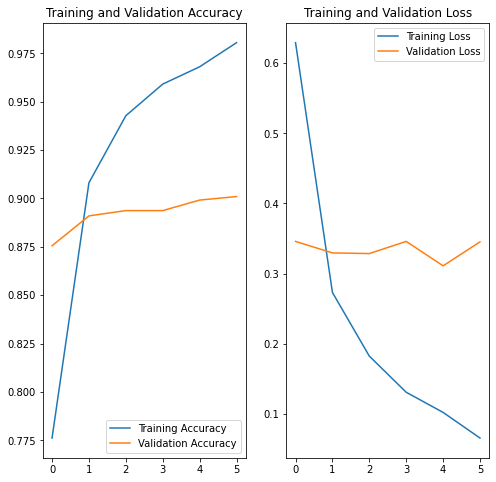

[0.7761775255203247, 0.9081354737281799, 0.9427793025970459, 0.9591280817985535, 0.9680809378623962, 0.9805371761322021]


In [22]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

What is a bit curious here is that validation performance is better than training performance, right from the start to the end of execution.

One reason for this is that validation performance is measured at the end of the epoch, but training performance is the average values across the epoch.

The bigger reason though is that we're reusing a large part of MobileNet which is already trained on Flower images. 

# TODO: Check Predictions

In the cell below get the label names from the dataset info and convert them into a NumPy array. Print the array to make sure you have the correct label names.

In [23]:
class_names = np.array(dataset_info.features['label'].names)

# printing array
print(class_names)

['dandelion' 'daisy' 'tulips' 'sunflowers' 'roses']


### Create an Image Batch and Make Predictions

In the cell below, use the `next()` function to create an `image_batch` and its corresponding `label_batch`. Convert both the `image_batch` and `label_batch` to numpy arrays using the `.numpy()` method. Then use the `.predict()` method to run the image batch through your model and make predictions. Then use the `np.argmax()` function to get the indices of the best prediction for each image. Finally convert the indices of the best predictions to class names.

In [24]:
image_batch, label_batch = next(iter(train_batches))


image_batch = image_batch.numpy()
label_batch = label_batch.numpy()

predicted_batch = model.predict(image_batch)
predicted_batch = tf.squeeze(predicted_batch).numpy()

predicted_ids = np.argmax(predicted_batch, axis=-1)
predicted_class_names = class_names[predicted_ids]

print(predicted_class_names)

['sunflowers' 'dandelion' 'daisy' 'sunflowers' 'daisy' 'dandelion'
 'dandelion' 'roses' 'roses' 'sunflowers' 'dandelion' 'tulips' 'tulips'
 'dandelion' 'daisy' 'tulips' 'sunflowers' 'roses' 'tulips' 'tulips'
 'sunflowers' 'tulips' 'daisy' 'dandelion' 'daisy' 'tulips' 'tulips'
 'tulips' 'roses' 'sunflowers' 'tulips' 'roses']


### TODO: Print True Labels and Predicted Indices

In the cell below, print the true labels and the indices of predicted labels.

In [33]:
# your code here
print("True labels: ", label_batch)
print("Indices of predicted labels ", predicted_ids)

True labels:  [3 0 1 3 1 0 0 4 4 3 0 2 2 0 1 2 3 4 2 2 3 2 1 0 1 2 2 2 4 3 2 4]
Indices of predicted labels  [3 0 1 3 1 0 0 4 4 3 0 2 2 0 1 2 3 4 2 2 3 2 1 0 1 2 2 2 4 3 2 4]
